In [1]:
# import all libraries and modules needed
import os
import sys
import datetime
import glob
import keras
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import SGD
import tensorflow
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
keras.__version__

'1.2.2'

In [3]:
tensorflow.__version__

'0.12.0'

In [4]:
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

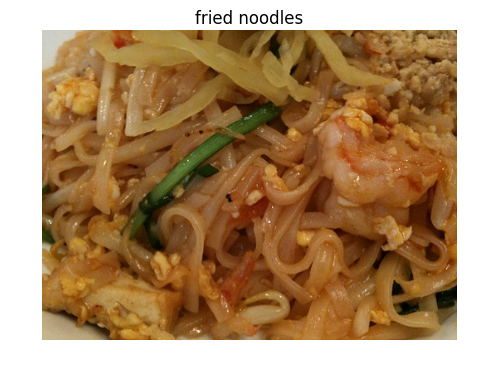

In [5]:
img = load_img('data/train/noodles_fried/4012787089_d1cca54838.jpg')
plt.imshow(img)
plt.axis('off')
plt.title('fried noodles')
plt.show()

In [6]:
x = img_to_array(img)
x2 = x.reshape((1,) + x.shape)

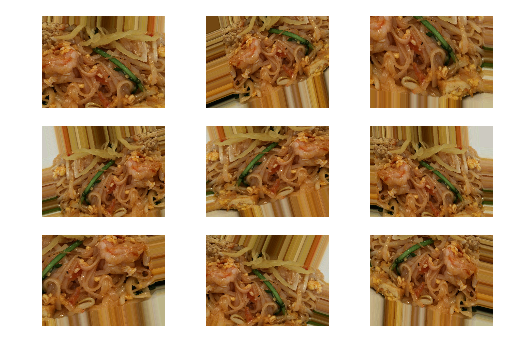

In [7]:
i = 0
fig = plt.figure()
plt.title('Pre-processed')
for batch in datagen.flow(x2, batch_size = 1):
    i += 1
    if i > 9:
        break
    temp = batch.reshape(x.shape)
    plt.subplot(3, 3, i)
    plt.imshow(temp.astype('uint8'))
    plt.axis('off')
plt.show()

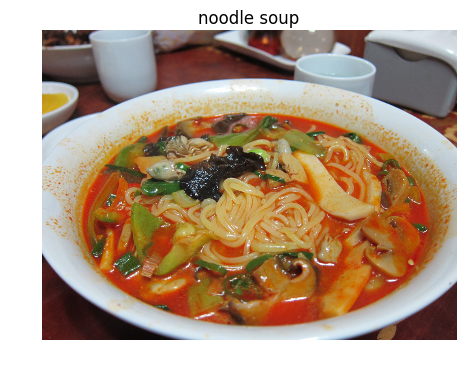

In [8]:
img = load_img('data/train/noodle_soup/5153183161_eb845fb8d9_b.jpg')
plt.imshow(img)
plt.axis('off')
plt.title('noodle soup')
plt.show()

In [9]:
# default settings
img_width, img_height = 299, 299

train_dir = 'data/train'
validate_dir = 'data/validate'
nb_epochs = 2
batch_size = 32
nb_classes = len(glob.glob(train_dir + '/*'))

In [10]:
# get number of images in training directory
nb_train_samples = 0
for r, dirs, files in os.walk(train_dir):
    for dr in dirs:
        nb_train_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(nb_train_samples)

315


In [11]:
# get number of images in validation directory
nb_validate_samples = 0
for r, dirs, files in os.walk(validate_dir):
    for dr in dirs:
        nb_validate_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(nb_validate_samples)

36


In [12]:
# data pre-processing for training
train_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [13]:
# data pre-processing for validating
validate_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [14]:
# generate and store training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 315 images belonging to 2 classes.


In [15]:
# generate and store validation data
validate_generator = validate_datagen.flow_from_directory(
    validate_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 36 images belonging to 2 classes.


In [16]:
# set up transfer learning on pre-trained ImageNet Inception_V3 model - remove fully connected layer and replace
# with softmax for classifying 2 classes
incepV3_model = InceptionV3(weights = 'imagenet', include_top = False, input_shape =(img_width, img_height, 3))
x = incepV3_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(nb_classes, activation = 'softmax')(x)
model = Model(input = incepV3_model.input, output = predictions)

In [17]:
# freeze all layers of the pre-trained model
for layer in incepV3_model.layers:
    layer.trainable = False

In [18]:
# compile the new model using a RMSProp optimizer
model.compile(optimizer = 'rmsprop',
    loss = 'binary_crossentropy',
    metrics = ['accuracy'])

In [19]:
# fit the model, log the results and the training time
now = datetime.datetime.now
t = now()
transfer_learning_history = model.fit_generator(
    train_generator,
    nb_epoch = nb_epochs,
    samples_per_epoch = nb_train_samples,
    validation_data = validate_generator,
    nb_val_samples = nb_validate_samples,
    class_weight='auto')
print('Training time: %s' % (now() - t))

Epoch 1/2
315/315 [==============================] - 157s - loss: 0.6009 - acc: 0.8095 - val_loss: 0.6517 - val_acc: 0.8056
Epoch 2/2
315/315 [==============================] - 151s - loss: 0.2541 - acc: 0.9111 - val_loss: 1.0128 - val_acc: 0.7778
Training time: 0:05:09.835557


In [20]:
# evaluate the performance the new model and report the results
score = model.evaluate_generator(validate_generator, nb_validate_samples/batch_size, pickle_safe=False)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 1.2010807991
Test Accuracy: 0.75


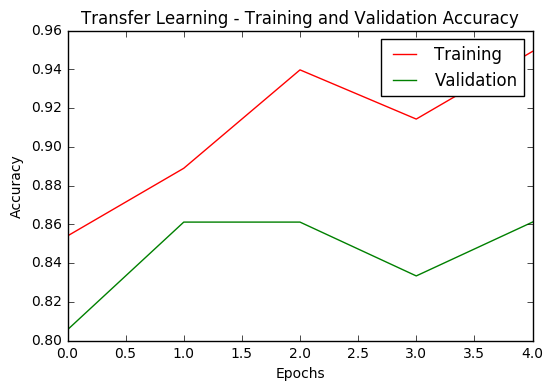

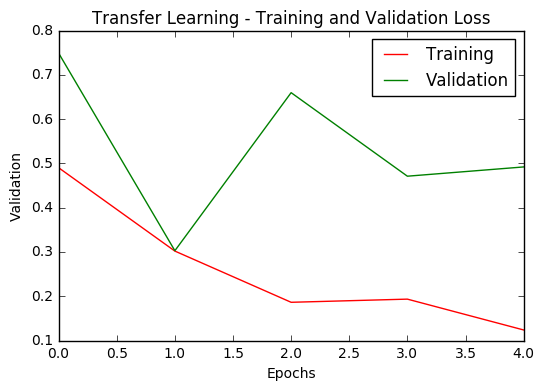

In [14]:
# plot the accuracy and loss data
xfer_acc = transfer_learning_history.history['acc']
val_acc = transfer_learning_history.history['val_acc']
xfer_loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']
epochs = range(len(xfer_acc))

plt.figure()
plt.plot(epochs, xfer_acc, 'r-', label = 'Training')
plt.plot(epochs, val_acc, 'g-', label = 'Validation')
plt.title('Transfer Learning - Training and Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, xfer_loss, 'r-', label = 'Training')
plt.plot(epochs, val_loss, 'g-', label = 'Validation')
plt.title('Transfer Learning - Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Validation")
plt.legend()
plt.show()

In [21]:
model.save('noodles_model_tl.h5')  # creates a HDF5 file 'my_model.h5'

In [22]:
classes = train_generator.class_indices
classes = {value : key for key, value in classes.items()}
classes[0]

'noodle_soup'

In [23]:
classes[1]

'noodles_fried'

In [24]:
print(len(classes))

2


In [25]:
print(classes)

{0: 'noodle_soup', 1: 'noodles_fried'}


In [ ]:
# display the layers in the pretrained model
for i, layer in enumerate(incepV3_model.layers):
   print(i, layer.name)

In [ ]:
# display the details of the model
model.summary()

In [17]:
# Step 1 - Set up fine tuning on pre-trained ImageNet Inception_V3 model - freeze lower 94 layers only
for layer in model.layers[:94]:
    layer.trainable = False
for layer in model.layers[94:]:
    layer.trainable = True

# Step 2 - Compile the revised model using SGD optimizer with a learing rate of 0.0001 and a momentum of 0.9
model.compile(optimizer = SGD(lr = 0.0001, momentum=0.9), 
    loss = 'binary_crossentropy',
    metrics = ['accuracy'])

# Step 3 - Fit the revised model, log the results and the training time
now = datetime.datetime.now
t = now()
fine_tuning_history = model.fit_generator(
    train_generator,
    nb_epoch = nb_epochs,
    samples_per_epoch = nb_train_samples,
    validation_data = validate_generator,
    nb_val_samples = nb_validate_samples,
    class_weight='auto')
print('Training time: %s' % (now() - t))

Epoch 1/5
315/315 [==============================] - 245s - loss: 0.0872 - acc: 0.9683 - val_loss: 0.2467 - val_acc: 0.9167
Epoch 2/5
315/315 [==============================] - 244s - loss: 0.0919 - acc: 0.9651 - val_loss: 0.6601 - val_acc: 0.8611
Epoch 3/5
315/315 [==============================] - 239s - loss: 0.0496 - acc: 0.9841 - val_loss: 0.7364 - val_acc: 0.8889
Epoch 4/5
315/315 [==============================] - 240s - loss: 0.0888 - acc: 0.9619 - val_loss: 0.4295 - val_acc: 0.9167
Epoch 5/5
315/315 [==============================] - 236s - loss: 0.0983 - acc: 0.9651 - val_loss: 0.3972 - val_acc: 0.8889
Training time: 0:20:23.023309


In [18]:
# evaluate the performance the revised model and report the results
score = model.evaluate_generator(validate_generator, nb_validate_samples/batch_size, pickle_safe=False)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.00902176648378
Test Accuracy: 1.0


In [20]:
model.save('noodles_model_ft.h5')  # creates a HDF5 file 'my_model.h5'

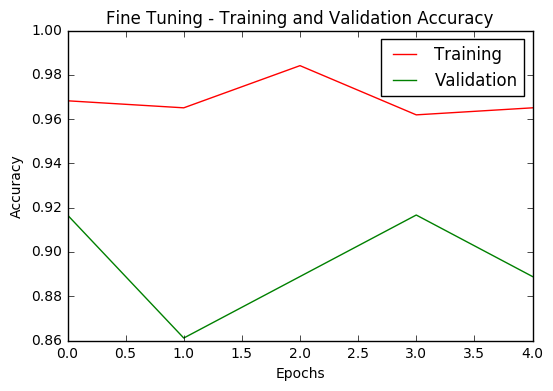

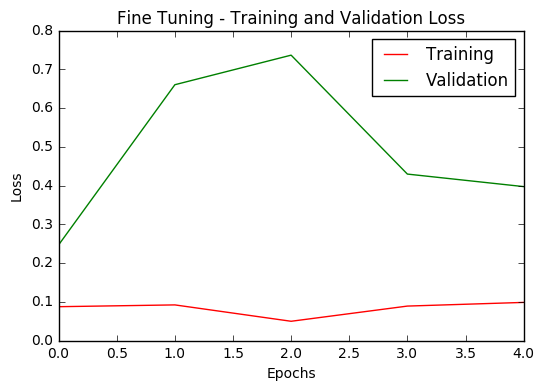

In [21]:
# plot the accuracy and loss data
ft_acc = fine_tuning_history.history['acc']
val_acc = fine_tuning_history.history['val_acc']
ft_loss = fine_tuning_history.history['loss']
val_loss = fine_tuning_history.history['val_loss']
epochs = range(len(ft_acc))

plt.plot(epochs, ft_acc, 'r-', label = 'Training')
plt.plot(epochs, val_acc, 'g-', label = 'Validation')
plt.title('Fine Tuning - Training and Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, ft_loss, 'r-', label = 'Training')
plt.plot(epochs, val_loss, 'g-', label = 'Validation')
plt.title('Fine Tuning - Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [38]:
from keras.models import load_model
loaded_model = load_model('noodles_model_ft.h5')
print("Loaded model from disk")

Loaded model from disk


In [34]:
# Step 2 - Compile the revised model using SGD optimizer with a learing rate of 0.0001 and a momentum of 0.9
loaded_model.compile(optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

In [55]:
def pred(img_for_recog):
    img = image.load_img(img_for_recog, target_size = (299, 299, 3))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = loaded_model.predict(x)
    # decode the results into a list of tuples (class, description, probability)
    # (one such list for each sample in the batch)
    #print('Predicted:', decode_predictions(preds, top = 5)[0])
    outcome = [np.argmax(loaded_model.predict(x))]
    #print(preds)
    print(outcome)

In [56]:
def display_img(img_for_display):
    img = load_img(img_for_display)
    plt.imshow(img)
    plt.axis('off')
    plt.title(img_for_display.rsplit('/')[1].rsplit('.')[0])
    plt.show()

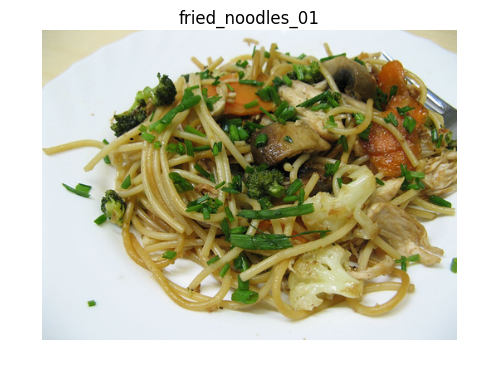

[1]


In [57]:
from keras.preprocessing import image
import numpy as np
img_path = 'images/fried_noodles_01.jpg'
display_img(img_path)
pred(img_path)

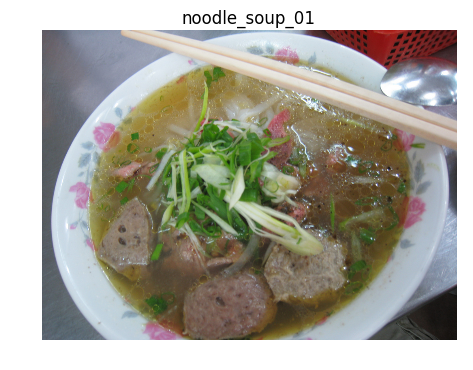

[0]


In [58]:
img_path = 'images/noodle_soup_01.jpg'
display_img(img_path)
pred(img_path)

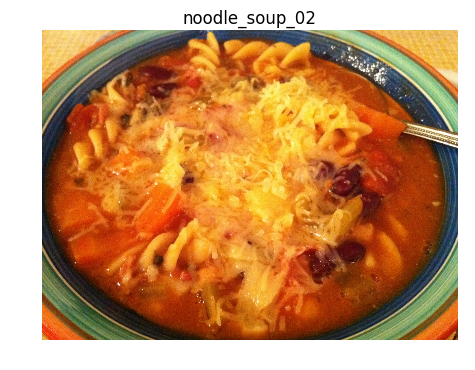

[0]


In [59]:
img_path = 'images/noodle_soup_02.jpg'
display_img(img_path)
pred(img_path)

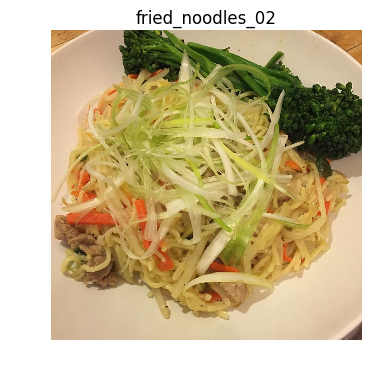

[1]


In [60]:
img_path = 'images/fried_noodles_02.jpg'
display_img(img_path)
pred(img_path)